# Generating MNIST Digits w/ Generative Adversarial Networks

Gage DeZoort and Jon Halverson\
3/25/24\
\
Based on [this GAN tutorial](https://https://www.kaggle.com/code/songseungwon/pytorch-gan-basic-tutorial-for-beginner) on Kaggle.

# Generative Adversarial Networks(GAN) - PyTorch Tutorial

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHwq72%2FbtqAY6E0wYb%2FBFRgtJWTY3Ij9BKks7vsM1%2Fimg.png)


Generative Adversarial Networks (GANs) are generative models, meaning they're designed to produce new data. The working principle is simple: two neural networks networks (the Generator and Discriminator) with competing objectives are trained against each other. The generator's goal is to produce realistic data, while the discriminator's goal is to decide whether data is fake (created by the generator) or real (belonging to the training/test set).

Several implementations of the GAN are available here: [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)


## Index
Here's a quick look at what we'll be doing:
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Configure Data Loader
Step 9. Define Optimizers
Step 10. Training
```
---

### Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

print(torch.__version__)

2.2.1+cu121


### Step 2. Initial setting

We're going to be analyzing the MNIST images again; recall that they're 28x28 greyscale images (i.e. one feature dimension per pixel).

In [2]:
channels = 1 # 1, number of image channels (gray scale)
img_size = 28 # 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (channels, image height, image width)

Here's a graphic to show what exactly we're going to code up:

![GAN](https://developers.google.com/machine-learning/gan/images/gan_diagram.svg "gan")

The generator is going to generate images based on 100 random noise inputs. You can think about these noise inputs as "instructions" for the type of image to be generated.

In [3]:
latent_dim = 100 # dimensionality

Last, let's make sure we can talk to the GPU:

In [4]:
cuda = True if torch.cuda.is_available() else False # GPU Setting
print(cuda)

True


### Step 3. Define Generator

With out initial dimensions taken care of, we'll turn to defining a generator module. We're not going to break out the heavy CNN machinery; instead we'll try to generate flattened MNIST digits using a standard feed-forward deep NN.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # each block is a combination of (Linear, LeakyReLU)
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers # return list of layers

        # DNN: 100->128->256->512->1024->784 (flattened 28x28 image)
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, img_size**2), # produce 28x28=784 dimensional outputs
            nn.Tanh() # result : from -1 to 1
        )

    # input z (latent vector) containing random variables
    def forward(self, z):
        img = self.model(z) # (batch_size, 100) -> (batch_size, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == batch_size
        return img

Let's make sense of the dimensions:

In [9]:
# study the generator
g = Generator()

# latent variables to feed the generator
g.eval()
z = torch.normal(mean=0, std=1, size=(1,100))
g(z).shape

# [batch_size, num_features, pixel_rows, pixel_cols]

torch.Size([1, 1, 28, 28])

> Read More
- [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- [Tanh](https://wiki.documentfoundation.org/Documentation/Calc_Functions/TANH)
- [Unpacking Operators in Python](https://towardsdatascience.com/unpacking-operators-in-python-306ae44cd480)

### Step 4. Define Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # DNN: 784->512->256->1 dimensions
        self.model = nn.Sequential(
            nn.Linear(img_size**2, 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # normalize output into range [0,1]
        )

    # input image from generator or discriminator
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # (64, 784) -> (64, 1), real vs. fake prediction
        return validity

Let's study the discriminator:

In [13]:
# study the generator
d = Discriminator()
print(d)

# latent variables to feed the generator
d.eval()
img = torch.normal(mean=0, std=1, size=(1,1,28,28))
pred = d(img)
print(pred, pred.shape)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
tensor([[0.4436]], grad_fn=<SigmoidBackward0>) torch.Size([1, 1])


### Step 5. Define Loss Function

Our loss function will compare the Discriminator's predictions to ground truth. Real images will be assigned `1` and fake images `0`. The output of the discriminator will be some number in the range `(0,1)` for each image. We'll use binary cross entropy (BCE) to compare the predicted probabilities to the targets; check out the [BCELoss PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) if you'd like to learn more about it!

In [14]:
adversarial_loss = torch.nn.BCELoss()

> Read More
- [BCELoss(Binary Cross Entropy Loss)](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

### Step 6. Initialize Generator and Discriminator

Let's instantiate a Generator and Discriminator and double-check what they're made of.


In [15]:
generator = Generator()
discriminator = Discriminator()

In [16]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [17]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Step 7. GPU Setting
Ship everything off to the GPU!

In [18]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Step 8. Configure Data Loader

This tutorial grabs MNIST from Kaggle. We'll use a `DatasetMNIST` class to load it up; the details aren't super improtant. We'll then use the [Pytorch Dataset and DataLoader](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader) to produce batches of data.


In [19]:
import pandas as pd
from torch.utils.data import Dataset

In [20]:
class DatasetMNIST(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [21]:
# train.csv is 74 MB
# data taken from https://www.kaggle.com/code/songseungwon/pytorch-gan-basic-tutorial-for-beginner/input
train = pd.read_csv('https://tigress-web.princeton.edu/~jdh4/intro_ml/gan/train.csv')

In the previous cell, we loaded up the dataset as a `Pandas` dataframe. We can take a look at the dataset in the cell below. You should find that each row corresponds to an image. The columns correspond to the truth label for the image, then every one of the 784 pixel values.

In [ ]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Digging into the `DatasetMNIST` class, we can check for 5 images that the `__getitem__` function does indeed load images in the correct shape.

Shape of Image :  (28, 28, 1)
label :  0


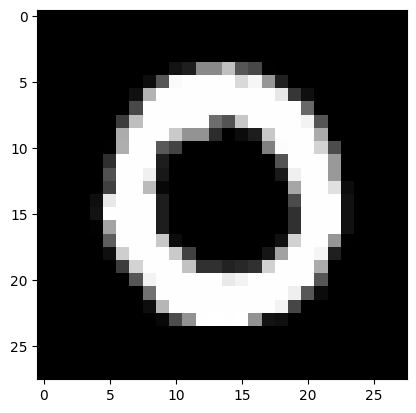

Shape of Image :  (28, 28, 1)
label :  1


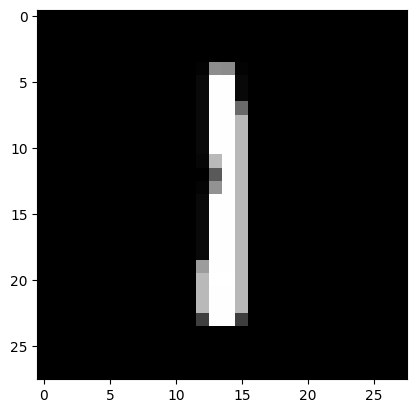

Shape of Image :  (28, 28, 1)
label :  4


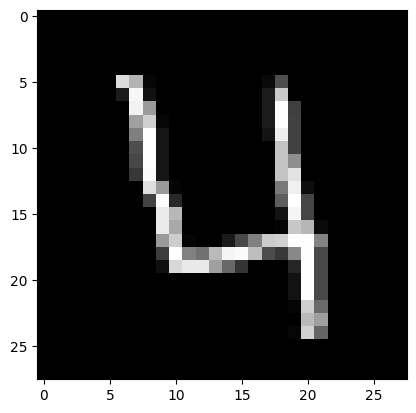

Shape of Image :  (28, 28, 1)
label :  0


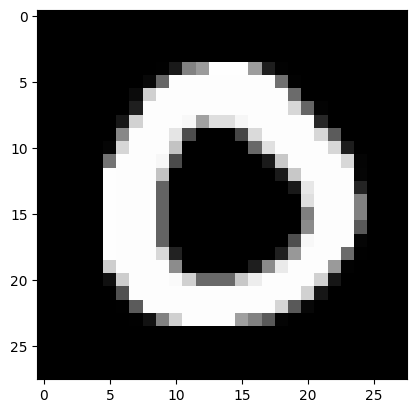

Shape of Image :  (28, 28, 1)
label :  0


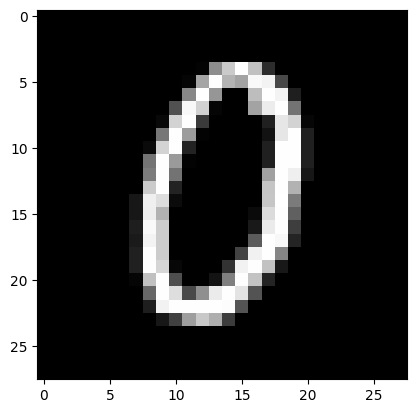

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)
    imshow(temp_image, cmap='gray', vmin=0, vmax=255)
    plt.show()

Okay, good, we have images. Let's load them up.

In [23]:
dataset = DatasetMNIST(
  file_path='https://tigress-web.princeton.edu/~jdh4/intro_ml/gan/train.csv',
  transform=transforms.Compose(
    [
    transforms.ToTensor(), # ensures shape is (channels, height, width)
    transforms.Normalize([0.5],[0.5]) # normalize images to range [-1, 1]
    ]
  )
)

In [24]:
# check that image has the correct size
temp_img, _ =  dataset.__getitem__(0)
temp_img.size()

torch.Size([1, 28, 28])

In [25]:
# check that image has the correct normalization
temp_img.max(), temp_img.min()

(tensor(1.), tensor(-1.))

We're going to train using batches of 64 images. This means that our input data will have a shape `(64,1,28,28)`.


In [26]:
batch_size = 64
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)
temp_images, _ = next(iter(dataloader))
temp_images.size()

torch.Size([64, 1, 28, 28])

> Read More
1. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
    - .ToTensor | Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
    - .ToTensor | Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

### Step 9. Define optimizers

Above we defined the `adversarial_loss`. To train the GAN we need to optimize this objective in two ways:

1. Reward the Generator for tricking the Discriminator. The Generator's weights will be tuned accordingly by `optimizer_G`.
2. Reward the Discriminator for sussing out the Generator. The Discriminator's weights will be tuned accordingly by `optimizer_D`.

In [27]:
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

### Step 10. Training

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpMdme%2FbtqA1ArBCOy%2FqqGg7IvV0hpqVkvBuEFpJK%2Fimg.png)

In [28]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Below you'll see our training loop. The high level structure is:
```
for each epoch:
  for each batch of images:
    imgs = batch of images (dim 64x1x784)

```

  0%|          | 0/657 [00:00<?, ?it/s]

<ipython-input-29-9620729c7f5a>:11: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))


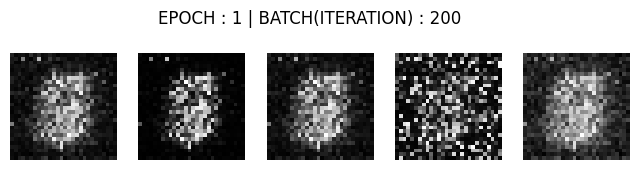

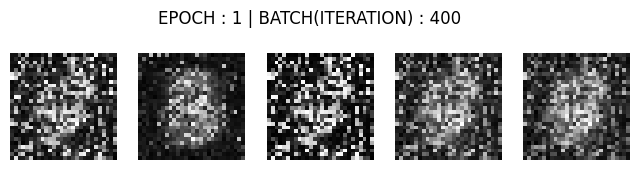

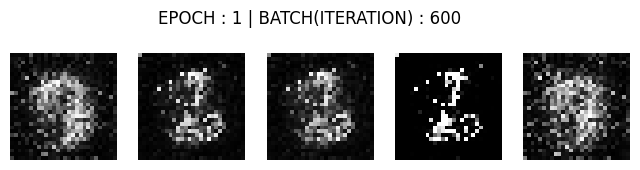

[Epoch: 1/200] [Batch: 657/657] [D loss: 0.350083] [G loss: 0.985202]


  0%|          | 0/657 [00:00<?, ?it/s]

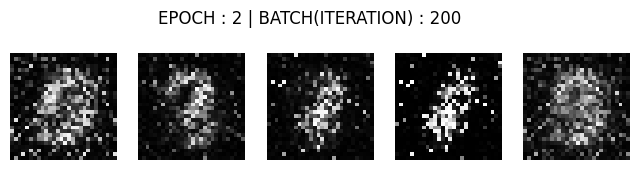

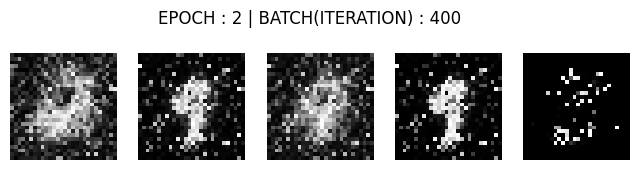

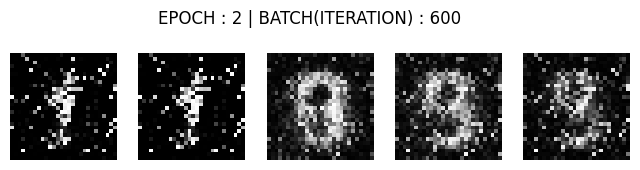

[Epoch: 2/200] [Batch: 657/657] [D loss: 0.532182] [G loss: 2.001541]


  0%|          | 0/657 [00:00<?, ?it/s]

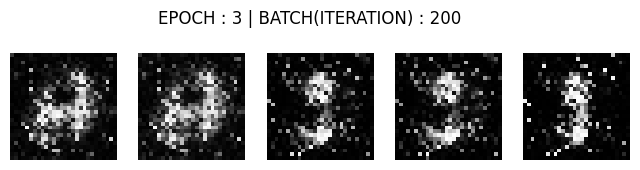

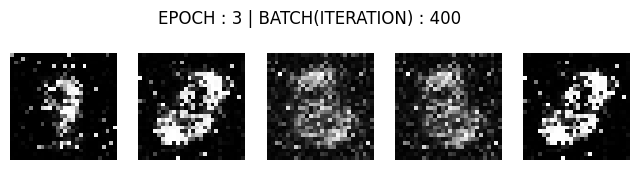

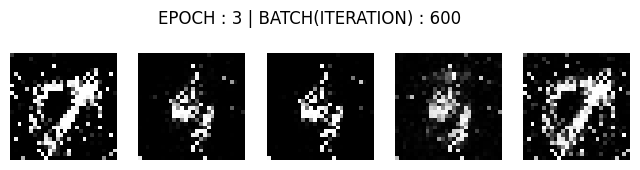

[Epoch: 3/200] [Batch: 657/657] [D loss: 0.255713] [G loss: 3.123974]


  0%|          | 0/657 [00:00<?, ?it/s]

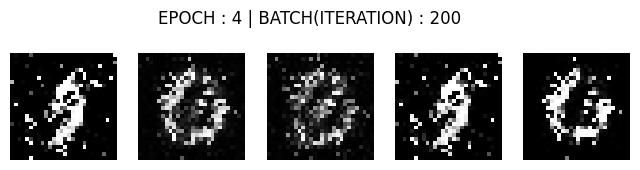

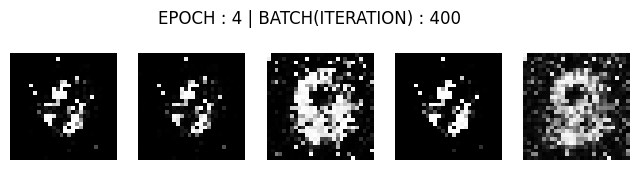

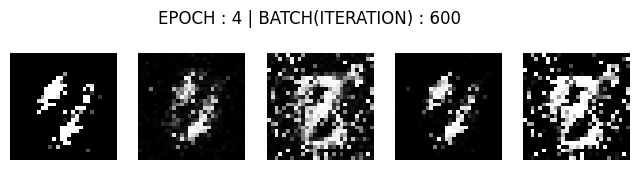

[Epoch: 4/200] [Batch: 657/657] [D loss: 0.298851] [G loss: 2.054344]


  0%|          | 0/657 [00:00<?, ?it/s]

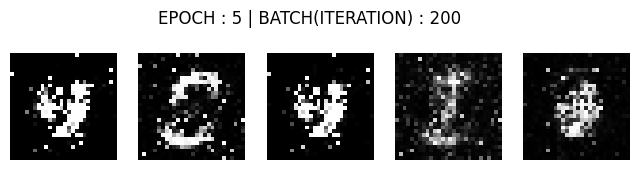

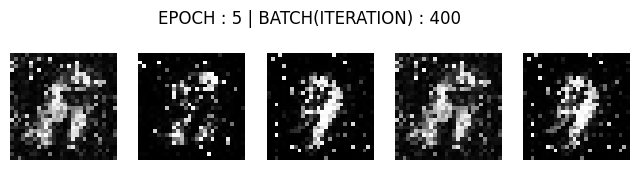

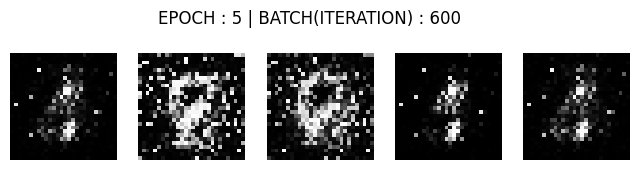

[Epoch: 5/200] [Batch: 657/657] [D loss: 0.283466] [G loss: 2.160771]


  0%|          | 0/657 [00:00<?, ?it/s]

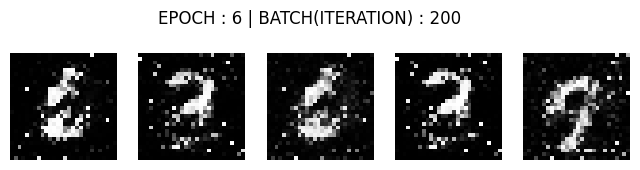

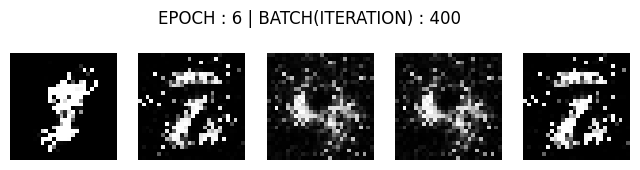

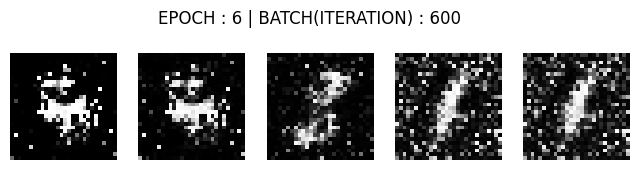

[Epoch: 6/200] [Batch: 657/657] [D loss: 0.505125] [G loss: 5.294124]


  0%|          | 0/657 [00:00<?, ?it/s]

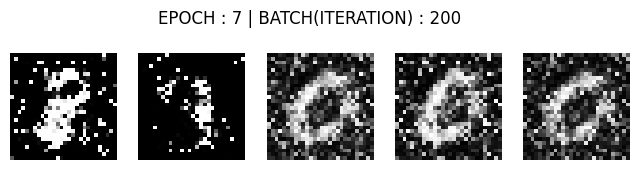

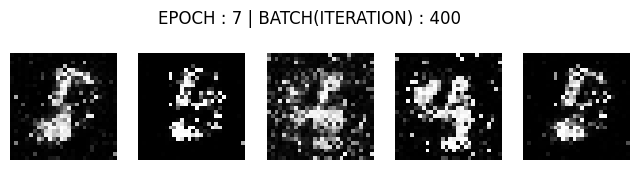

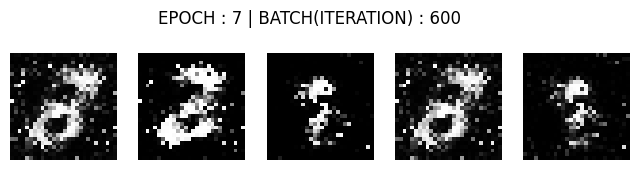

[Epoch: 7/200] [Batch: 657/657] [D loss: 0.241855] [G loss: 1.278852]


  0%|          | 0/657 [00:00<?, ?it/s]

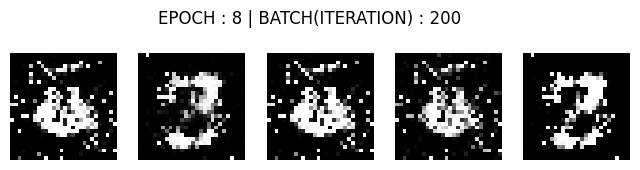

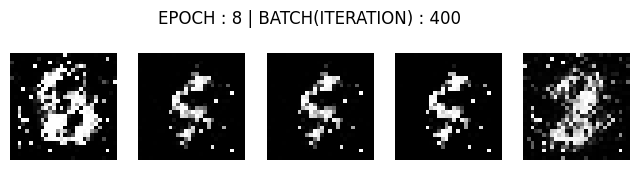

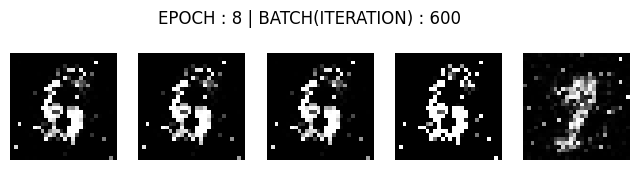

[Epoch: 8/200] [Batch: 657/657] [D loss: 0.237982] [G loss: 1.297848]


  0%|          | 0/657 [00:00<?, ?it/s]

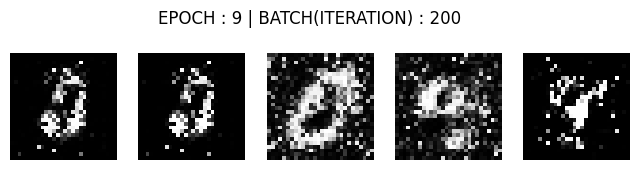

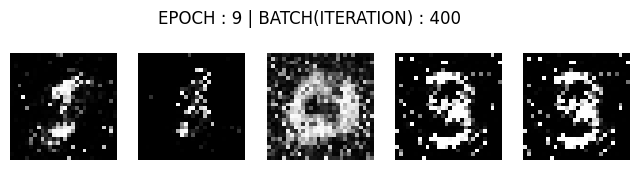

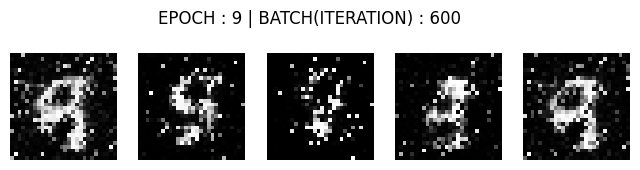

[Epoch: 9/200] [Batch: 657/657] [D loss: 0.237578] [G loss: 1.174385]


  0%|          | 0/657 [00:00<?, ?it/s]

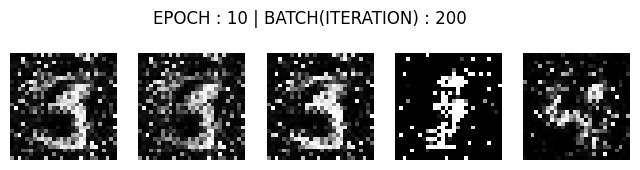

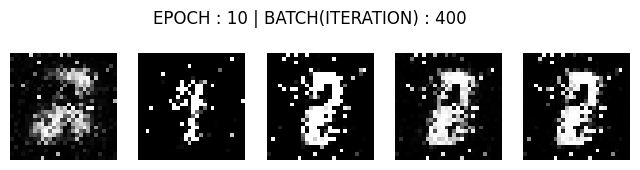

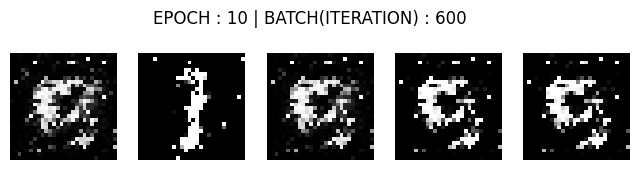

[Epoch: 10/200] [Batch: 657/657] [D loss: 0.152960] [G loss: 3.724085]


  0%|          | 0/657 [00:00<?, ?it/s]

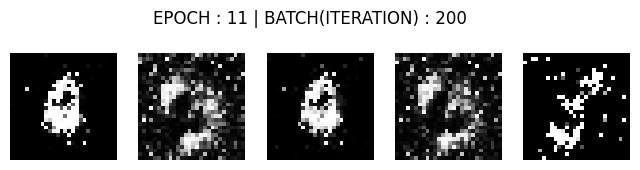

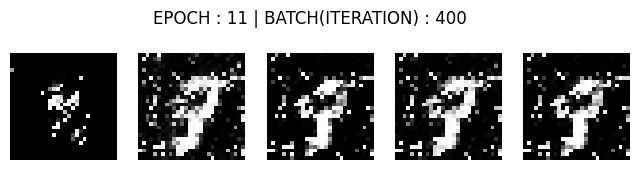

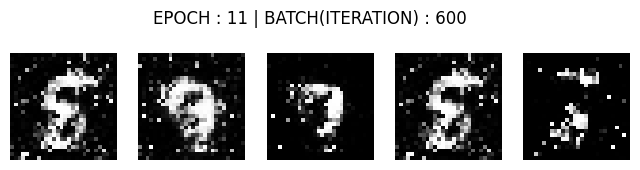

[Epoch: 11/200] [Batch: 657/657] [D loss: 0.330961] [G loss: 2.215576]


  0%|          | 0/657 [00:00<?, ?it/s]

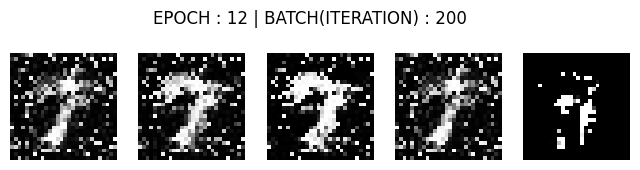

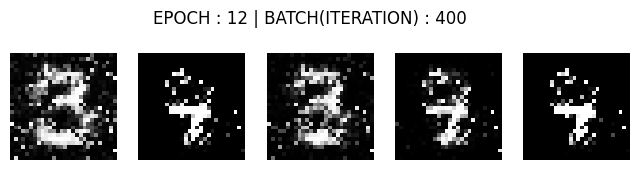

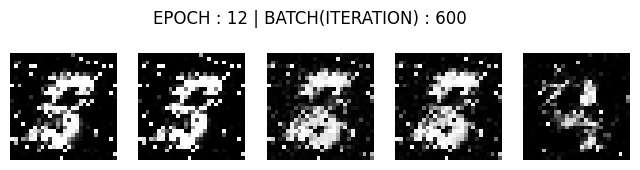

[Epoch: 12/200] [Batch: 657/657] [D loss: 0.066427] [G loss: 3.463345]


  0%|          | 0/657 [00:00<?, ?it/s]

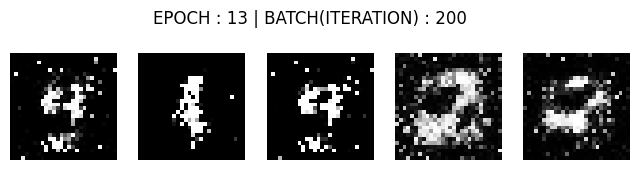

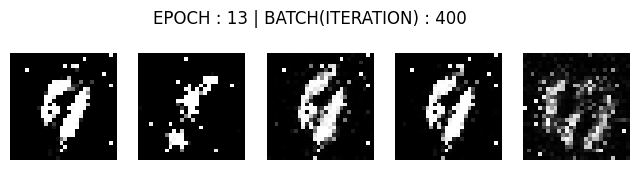

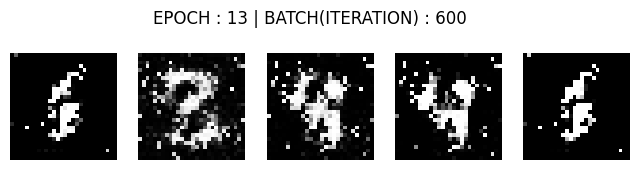

[Epoch: 13/200] [Batch: 657/657] [D loss: 0.385588] [G loss: 3.266579]


  0%|          | 0/657 [00:00<?, ?it/s]

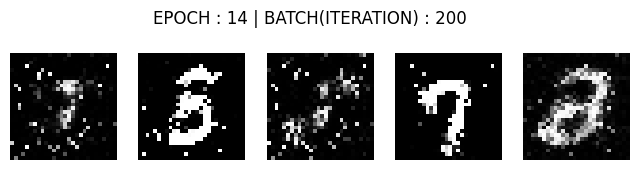

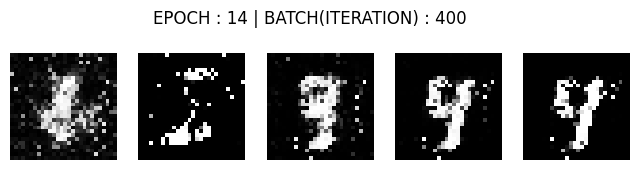

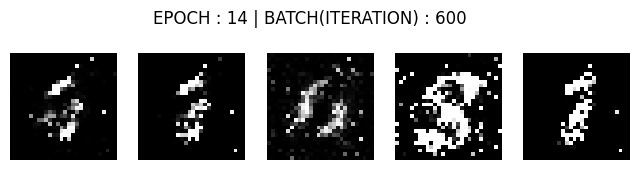

[Epoch: 14/200] [Batch: 657/657] [D loss: 0.150046] [G loss: 2.334865]


  0%|          | 0/657 [00:00<?, ?it/s]

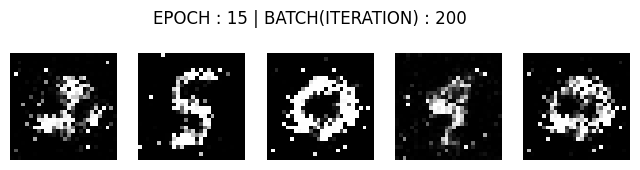

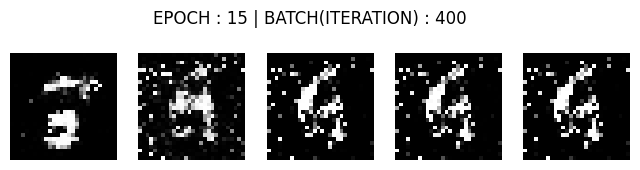

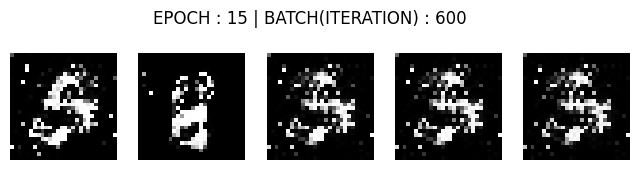

[Epoch: 15/200] [Batch: 657/657] [D loss: 0.207036] [G loss: 3.570252]


  0%|          | 0/657 [00:00<?, ?it/s]

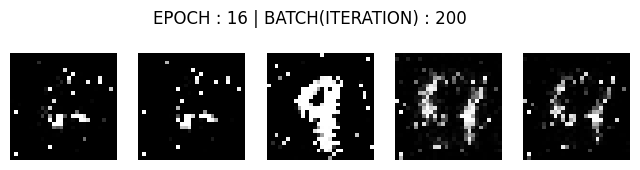

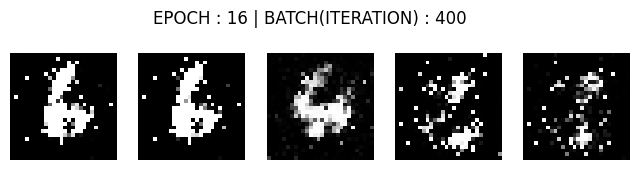

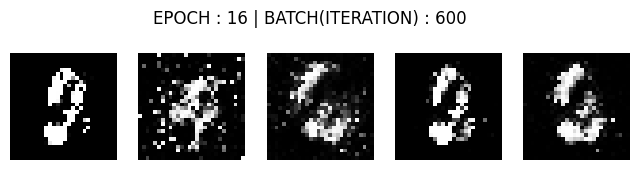

[Epoch: 16/200] [Batch: 657/657] [D loss: 0.088257] [G loss: 2.253098]


  0%|          | 0/657 [00:00<?, ?it/s]

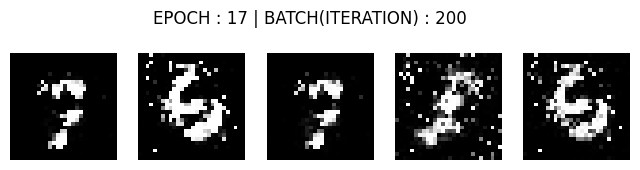

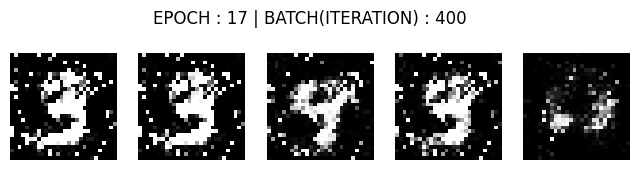

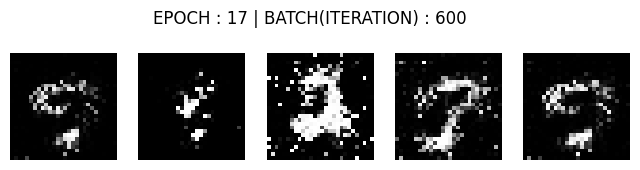

[Epoch: 17/200] [Batch: 657/657] [D loss: 0.236815] [G loss: 1.556785]


  0%|          | 0/657 [00:00<?, ?it/s]

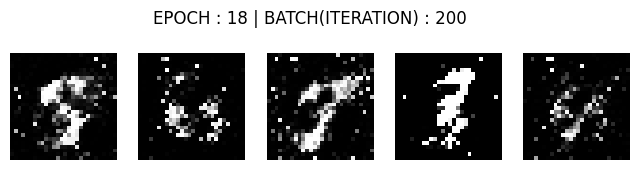

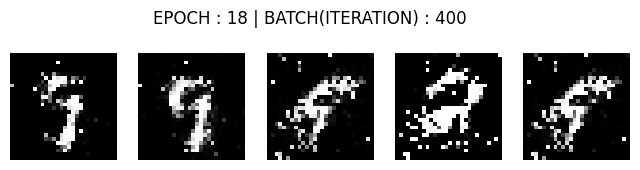

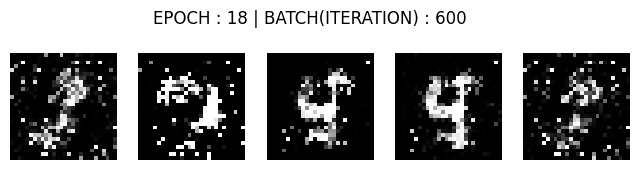

[Epoch: 18/200] [Batch: 657/657] [D loss: 0.191900] [G loss: 3.609391]


  0%|          | 0/657 [00:00<?, ?it/s]

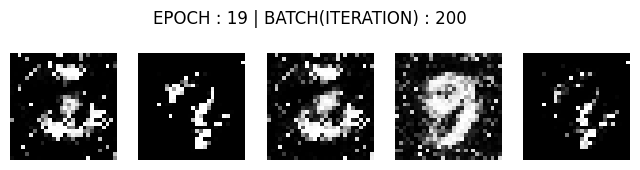

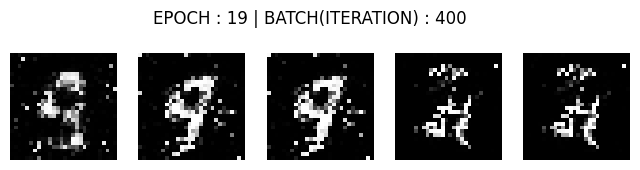

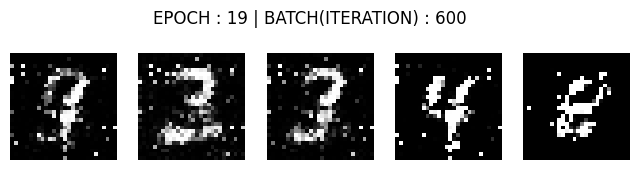

[Epoch: 19/200] [Batch: 657/657] [D loss: 0.203962] [G loss: 1.996027]


  0%|          | 0/657 [00:00<?, ?it/s]

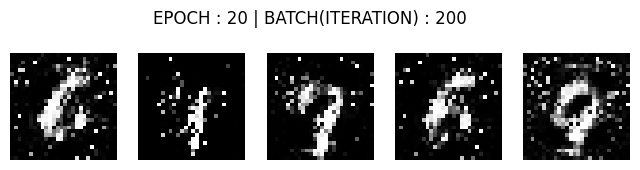

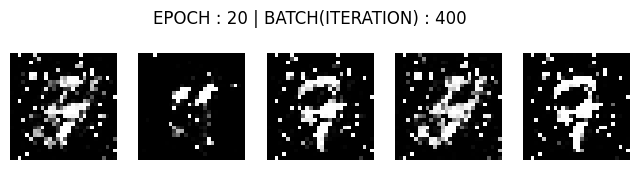

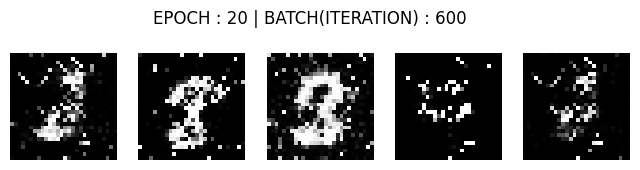

[Epoch: 20/200] [Batch: 657/657] [D loss: 0.369810] [G loss: 3.071648]


  0%|          | 0/657 [00:00<?, ?it/s]

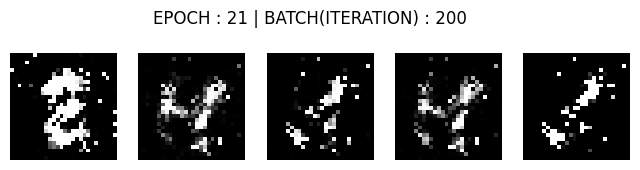

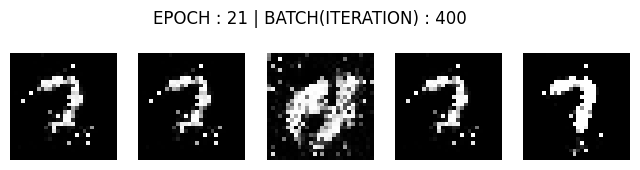

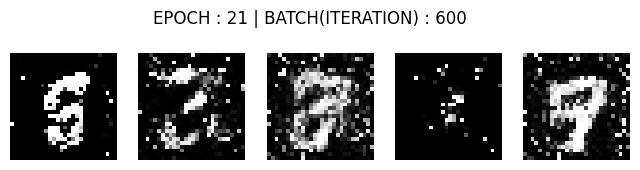

[Epoch: 21/200] [Batch: 657/657] [D loss: 0.224853] [G loss: 2.091807]


  0%|          | 0/657 [00:00<?, ?it/s]

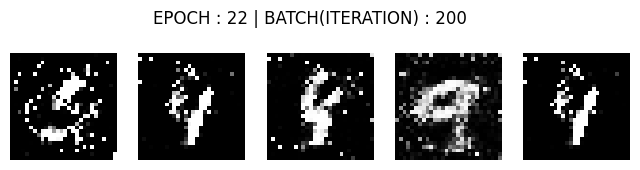

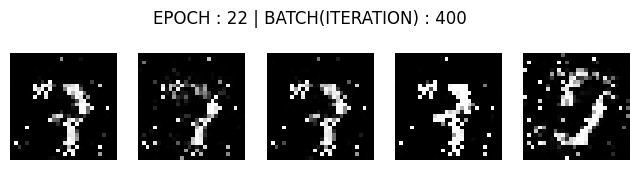

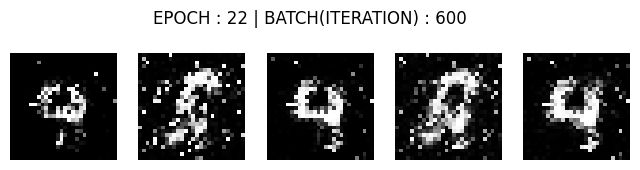

[Epoch: 22/200] [Batch: 657/657] [D loss: 0.162944] [G loss: 1.735635]


  0%|          | 0/657 [00:00<?, ?it/s]

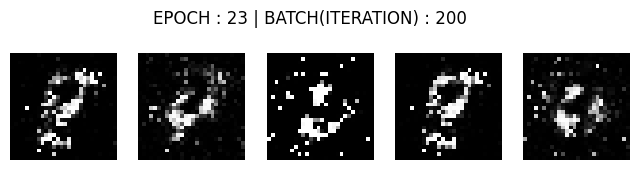

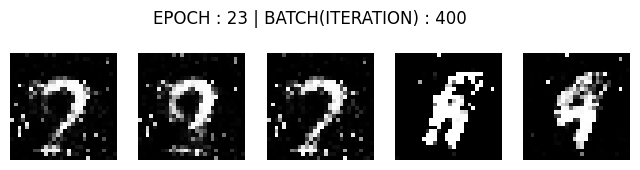

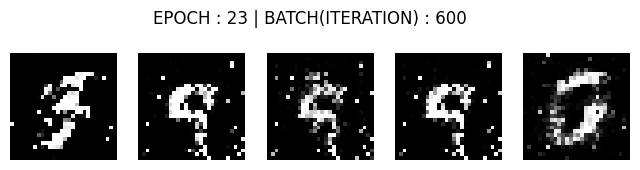

[Epoch: 23/200] [Batch: 657/657] [D loss: 0.135989] [G loss: 1.852196]


  0%|          | 0/657 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
n_epochs = 200 # though 200 is recommended in the original tutorial!
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)):

        # truth labels for training
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)
        real_imgs = imgs.type(Tensor) # the images in this batch are all real!

        # latent variables z are standard Gaussian variables (64x100)
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))

        # ship everything to GPU if applicable
        if cuda:
          valid, fake, z = valid.cuda(), fake.cuda(), z.cuda()

        ### --- train the generator --- ###

        # clear out the gradients from the previous batch
        optimizer_G.zero_grad()

        # ask generator to produce fake images
        gen_imgs = generator(z) # outputs (64x1x28x28)

        # ask the discriminator to classify the images
        d_pred = discriminator(gen_imgs)

        # penalize the generator where the discriminator isn't tricked
        g_loss = adversarial_loss(d_pred, valid)

        # gradient descent to update the generator weights
        g_loss.backward()
        optimizer_G.step()

        ### --- train the discriminator --- ###

        # clear the gradients from the previous batch
        optimizer_D.zero_grad()

        #  ask the discriminator to classisfy the real images (all valid)
        d_pred_real = discriminator(real_imgs)
        real_loss = adversarial_loss(d_pred_real, valid)

        # ask the discriminator to classify the Generator images (all fake)
        d_pred_fake = discriminator(gen_imgs.detach()) # detach the gradient (removes dependence on Generator)
        fake_loss = adversarial_loss(d_pred_fake, fake)

        # average the loss incurred in both cases
        d_loss = (real_loss + fake_loss) / 2

        # gradient descent to update hte weights
        d_loss.backward()
        optimizer_D.step()

        ### --- real-time visualization --- ###
        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        if ((i+1) % 200) == 0:
            nrows, ncols=1, 5
            fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()

    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

> TEST CODE : enumerate >> [docs.python.org/enumerate](https://docs.python.org/3/library/functions.html#enumerate)

--------------